In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, '../scripts')

import stft_zoom, display
from util import fft_frequencies, find_nearest
import mappings
import pickle
import PIL
import IPython.display
import detect_musical_regions

/Library/Python/3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Library/Python/3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
def half_bin_shift(y, window_size, sr):
    freq_shift = sr / (window_size * 2)
    y_shift = np.zeros(len(y), dtype='complex')
    for n in range(len(y)):
        y_shift[n] = np.exp(2*np.pi * 1j * n * freq_shift / sr ) * y[n]
    return y_shift

def calc_entropy_shifted(spectrogram, kernel_dimensions, n_fft=2048, hop_size=512, sr=44100):
    # kernel given in [freq. bins of 512 hz window res, time frames of 128 hop size res]
    
    delta_t = int(128 / hop_size * kernel_dimensions[1]) 
    delta_f = int((n_fft / 512) * kernel_dimensions[0])

    mapping = np.zeros([256 // kernel_dimensions[0], 3446//kernel_dimensions[1]])

    j = 0
    j_map = 0
    
    i = 0
    i_map = 0

    while j < spectrogram.shape[1] - delta_t:
        while i < spectrogram.shape[0] - delta_f:
            subregion = spectrogram[i:i+delta_f, j:j+delta_t]
            mapping[i_map, j_map] = mappings.shannon_entropy(subregion)
#             mapping[i_map, j_map] = np.mean(subregion)
            i += delta_f
            i_map += 1
            
        j += delta_t
        j_map += 1
        i_map = 0
        i = 0
    
    return mapping

# Get n spectrograms

def get_n_spectrograms(y, n=3):
    n_ffts = [512, 1024, 4096, 8192]
    spec_list = []
    for i in range(n):
        n_fft = n_ffts[i]
        hop_size = n_fft // 4
        spec_list.append([np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_size)), n_fft, hop_size])
        
    return spec_list

def get_entropies(specs, kernel):
    entropies = []
    for spec in specs:
        entropies.append(calc_entropy_shifted(spec[0], kernel, n_fft=spec[1], hop_size=spec[2]))
        
    return entropies

In [3]:
y, sr = librosa.load('../data/example.wav', sr=44100)

In [4]:
specs = get_n_spectrograms(y, n=3)
kernel = [16,16]

In [5]:
specs = get_n_spectrograms(y, n=3)
kernel = [16,16]

In [6]:
entropies = get_entropies(specs, kernel)

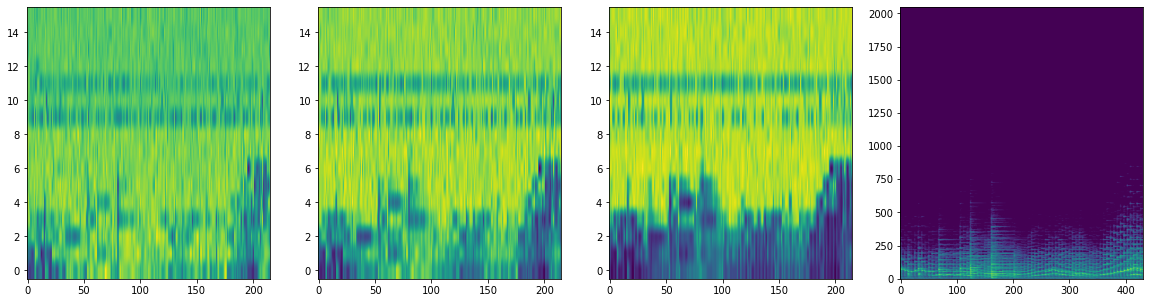

In [7]:
plt.figure(figsize=[20,5])

plt.subplot(1,4,1)
plt.imshow(entropies[0], origin='lower', aspect='auto')

plt.subplot(1,4,2)
plt.imshow(entropies[1], origin='lower', aspect='auto')

plt.subplot(1,4,3)
plt.imshow(entropies[2], origin='lower', aspect='auto')

plt.subplot(1,4,4)
plt.imshow(librosa.amplitude_to_db(specs[2][0]), origin='lower', aspect='auto')